In [325]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [326]:
# 한글 문제
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':  # 맥OS
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # 윈도우
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...  sorry~~~')

# CCTV데이터 전처리

In [327]:
cctv_df = pd.read_csv('./open/external_open/대구 CCTV 정보.csv', encoding="cp949", low_memory=False)
cctv_df['시군구명'] = cctv_df['시군구명'].replace({'달성': '달성군'})
# "단속구분"이 01인 행만 가져오기 단속구분은 int형임. 01->속도단속카메라
# cctv_df.info()
# # cctv_df['시군구명'].unique()
# cctv_df['소재지지번주소'].unique()

In [328]:

cctv_df = cctv_df.dropna(subset=['소재지지번주소'])
# cctv_df.isnull().sum()

# 소재지 지번주소로 세밀하게 cctv구역 설치구역 조사

In [329]:
# 아래 3가지 정보만 뽑아오기
cctv_addr = cctv_df[['무인교통단속카메라관리번호', '단속구분', '소재지지번주소']]
# cctv_addr.info()

In [330]:
# 동리만 뽑아내기. 동or리or로 만 존재하므로.
import re
cctv_addr_dong = cctv_addr.copy()
cctv_addr_dong['동리로'] = cctv_addr_dong['소재지지번주소'].apply(lambda x: re.search(r'\S+[동리로]', str(x)).group() if re.search(r'\S+[동리로]', str(x)) else '')
# cctv_addr_dong.info()

In [331]:
# 동, 리, 로의 등장횟수를 카운터해 cctv개수 카운팅

cctv_counts = cctv_addr_dong['동리로'].value_counts()
cctv_counts_df = cctv_counts.reset_index()
cctv_counts_df.columns = ['동리로', 'cctv설치개수']
# print(cctv_counts_df)

# 대구시 각 동별 CCTV개수 현황

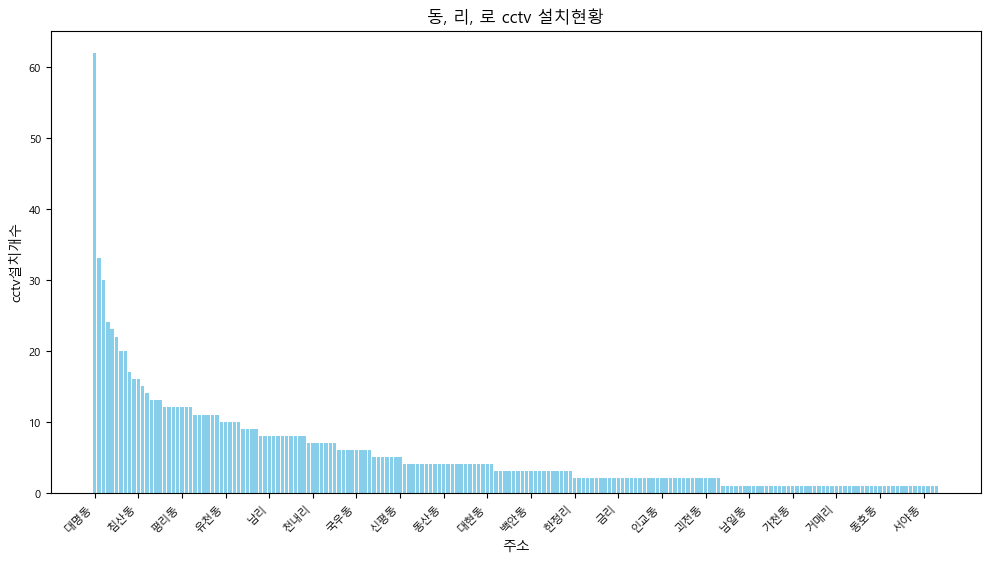

In [343]:
import matplotlib.pyplot as plt
# 횟수를 기준으로 내림차순 정렬
cctv_counts_df = cctv_counts_df.sort_values(by='cctv설치개수', ascending=False)
# 일정 간격으로 x축 라벨 표시
step = 10  # 라벨 간격 조절
plt.figure(figsize=(12, 6))
plt.bar(cctv_counts_df.index, cctv_counts_df['cctv설치개수'], color='skyblue')
plt.title('동, 리, 로 cctv 설치현황')
plt.xlabel('주소')
plt.ylabel('cctv설치개수')
plt.xticks(range(0, len(cctv_counts_df), step), cctv_counts_df['동리로'][::step], rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.show()
# x축이 너무 많아서 대표값만 표시

# 대구시 각 동별 CCTV개수 현황 4분활

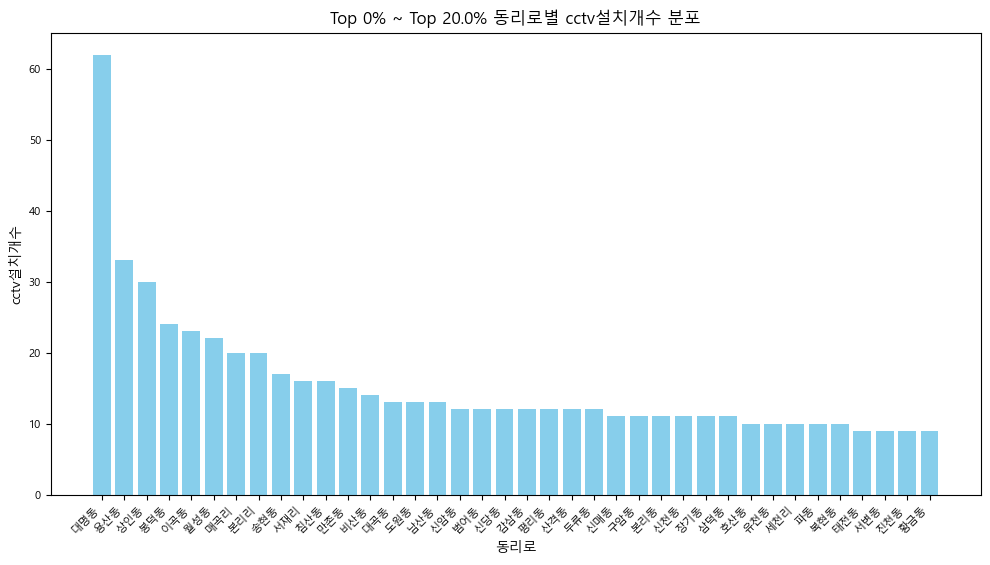

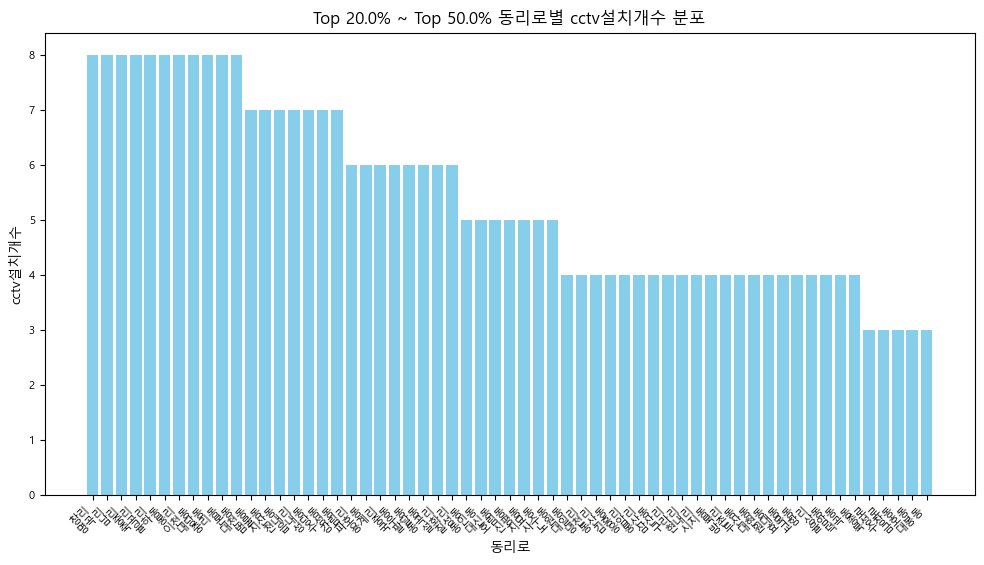

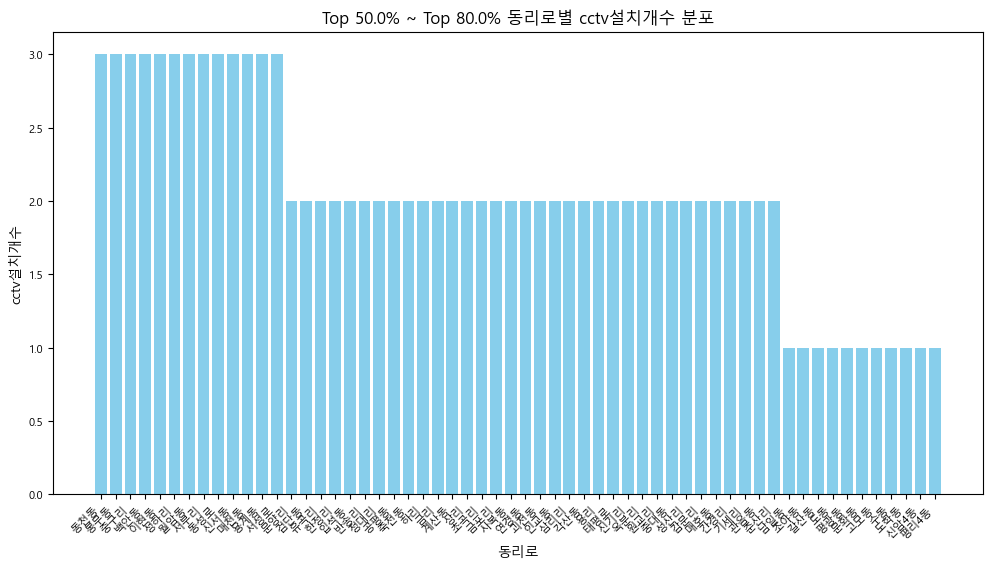

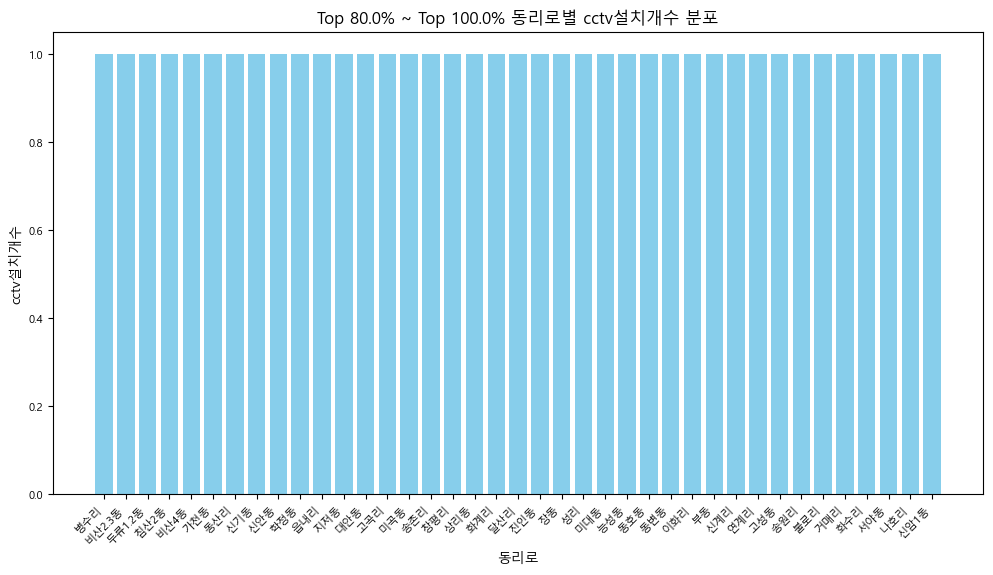

In [333]:
# 상위 n%의 데이터만 선택하는 함수
def select_top_percent(data, lower_percent, upper_percent):
    lower_bound = int(lower_percent * len(data))
    upper_bound = int(upper_percent * len(data))
    selected_data = data.iloc[lower_bound:upper_bound]
    return selected_data
# 각 구간별 히스토그램 생성
percent_ranges = [(0, 0.2), (0.2, 0.5), (0.5, 0.8), (0.8, 1.0)]
for lower_percent, upper_percent in percent_ranges:
    selected_data = select_top_percent(cctv_counts_df, lower_percent, upper_percent)
    # 히스토그램 표시
    plt.figure(figsize=(12, 6))
    plt.bar(selected_data['동리로'], selected_data['cctv설치개수'], color='skyblue')
    plt.title(f'Top {lower_percent*100}% ~ Top {upper_percent*100}% 동리로별 cctv설치개수 분포')
    plt.xlabel('동리로')
    plt.ylabel('cctv설치개수')
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(fontsize=8)
    plt.show()


# train데이터 전처리

In [334]:
train_df = pd.read_csv('./open/train.csv', encoding="UTF-8", low_memory=False)
#train_df['시군구명'] = cctv_df['시군구명'].replace({'달성': '달성군'})
# "단속구분"이 01인 행만 가져오기 단속구분은 int형임. 01->속도단속카메라
# train_df.info()
#train_df['시군구'].unique()

In [335]:
# cctv처럼 train도 위치에 대한 정보와 id만 뽑아와서 주소를 세밀화 하기
train_addr = train_df[['ID', '시군구', '사고유형', '법규위반', 'ECLO']]
# 추가로 동별 eclo 평균 구하기
average_eclo_by_dong = train_addr.groupby('시군구')['ECLO'].mean()
# "동리로"에 대한 ECLO 평균값을 가지고 있는 데이터프레임과 기존의 train 데이터프레임을 병합
train_with_avg_eclo = pd.merge(train_addr, average_eclo_by_dong, how='left', left_on='시군구', right_index=True, suffixes=('', '_평균값'))
# print(train_with_avg_eclo[['시군구', 'ECLO', 'ECLO_평균값']].head())
# average_eclo_by_dong.head()

In [336]:
train_addr_dong = train_with_avg_eclo.copy()
train_addr_dong['동리로'] = train_addr_dong['시군구'].apply(lambda x: re.search(r'\S+[동리로]', str(x)).group() if re.search(r'\S+[동리로]', str(x)) else '')
# print(train_addr_dong['동리로'].unique()) #train데이터의 주소
# print(cctv_counts_df['동리로'].unique()) #cctv데이터의 주소.
# 겹치지 않는값이 있는데? 찾아보자
unique_train_addr_dong = set(train_addr_dong['동리로'].unique())
unique_cctv_counts_dong = set(cctv_counts_df['동리로'].unique())
unique_in_train_not_in_cctv = unique_train_addr_dong - unique_cctv_counts_dong
unique_in_cctv_not_in_train = unique_cctv_counts_dong - unique_train_addr_dong
# print("Train 데이터에만 있는 동리로:", unique_in_train_not_in_cctv)
# print("CCTV 데이터에만 있는 동리로:", unique_in_cctv_not_in_train)
overlap_dong = set(train_addr_dong['동리로'].unique()) & set(cctv_counts_df['동리로'].unique())
# 겹치는 데이터 출력 우선 겹치는것만 해보자.
# print("겹치는 동리로:", overlap_dong)

In [337]:
# 겹치는 동리로를 가진 행 추출
filtered_train_data = train_addr_dong[train_addr_dong['동리로'].isin(overlap_dong)]
filtered_cctv_data = cctv_counts_df[cctv_counts_df['동리로'].isin(overlap_dong)]
# 동리로가 겹치는 샘플은 빼고 그래프에 표시하기 -> 이미 각 지역의(동리로의 ECLO)를 구했기 때문에
# 새로운 데이터프레임 출력
# print("Train 데이터프레임:")
# print(filtered_train_data.head())
# print(filtered_train_data.info())
# print("\nCCTV 데이터프레임:")
# print(filtered_cctv_data.head())
# print(filtered_cctv_data.info())

In [338]:
# "동리로"에 대한 중복 제거 후, 각 "동리로"에 대한 "ECLO평균"값 확인
unique_dong_eclo_avg = filtered_train_data.drop_duplicates(subset='동리로')[['동리로', 'ECLO_평균값']]
unique_dong_cctv_count = filtered_cctv_data.drop_duplicates(subset='동리로')[['동리로', 'cctv설치개수']]
# 결과 출력
# print(unique_dong_eclo_avg)
# print(unique_dong_cctv_count)

# 동별 CCTV 개수와 ECLO평균 그래프

동리로별 cctv설치개수 및 ECLO_평균값


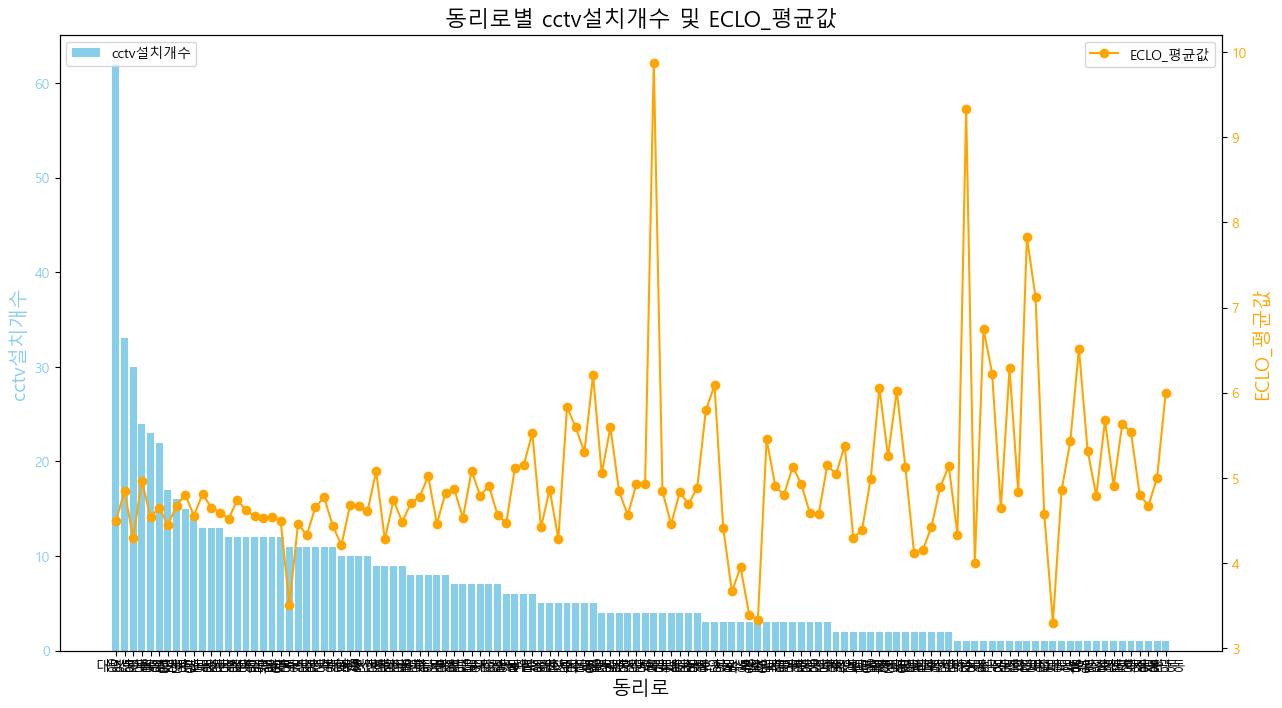

In [339]:
import matplotlib.pyplot as plt
# print(cctv_addr_dong['동리로'].unique())
# unique_dong_eclo_avg['동리로'].unique()cctv_addr_dong
merged_df = pd.merge(unique_dong_eclo_avg, cctv_counts_df, on='동리로', how='inner')
# 예시 데이터프레임 생성 (실제 데이터 프레임 사용)
ol_df = pd.DataFrame(merged_df)
# 데이터프레임을 'cctv설치개수' 기준으로 내림차순 정렬
ol_df = ol_df.sort_values(by='cctv설치개수', ascending=False)
fig, ax1 = plt.subplots(figsize=(15, 8))
# 막대 그래프 (cctv설치개수)
ax1.bar(ol_df['동리로'], ol_df['cctv설치개수'], color='skyblue', label='cctv설치개수')
ax1.set_xlabel('동리로', fontsize=14)
ax1.set_ylabel('cctv설치개수', color='skyblue', fontsize=14)
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.legend(loc='upper left')
# 선 그래프 (ECLO_평균값)
ax2 = ax1.twinx()
ax2.plot(ol_df['동리로'], ol_df['ECLO_평균값'], color='orange', marker='o', label='ECLO_평균값')
ax2.set_ylabel('ECLO_평균값', color='orange', fontsize=14)
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='upper right')
plt.title('동리로별 cctv설치개수 및 ECLO_평균값', fontsize=16)
plt.xticks(rotation=45, ha='right')
print('동리로별 cctv설치개수 및 ECLO_평균값')

# 동별 CCTV 개수와 ECLO평균 그래프 8분활

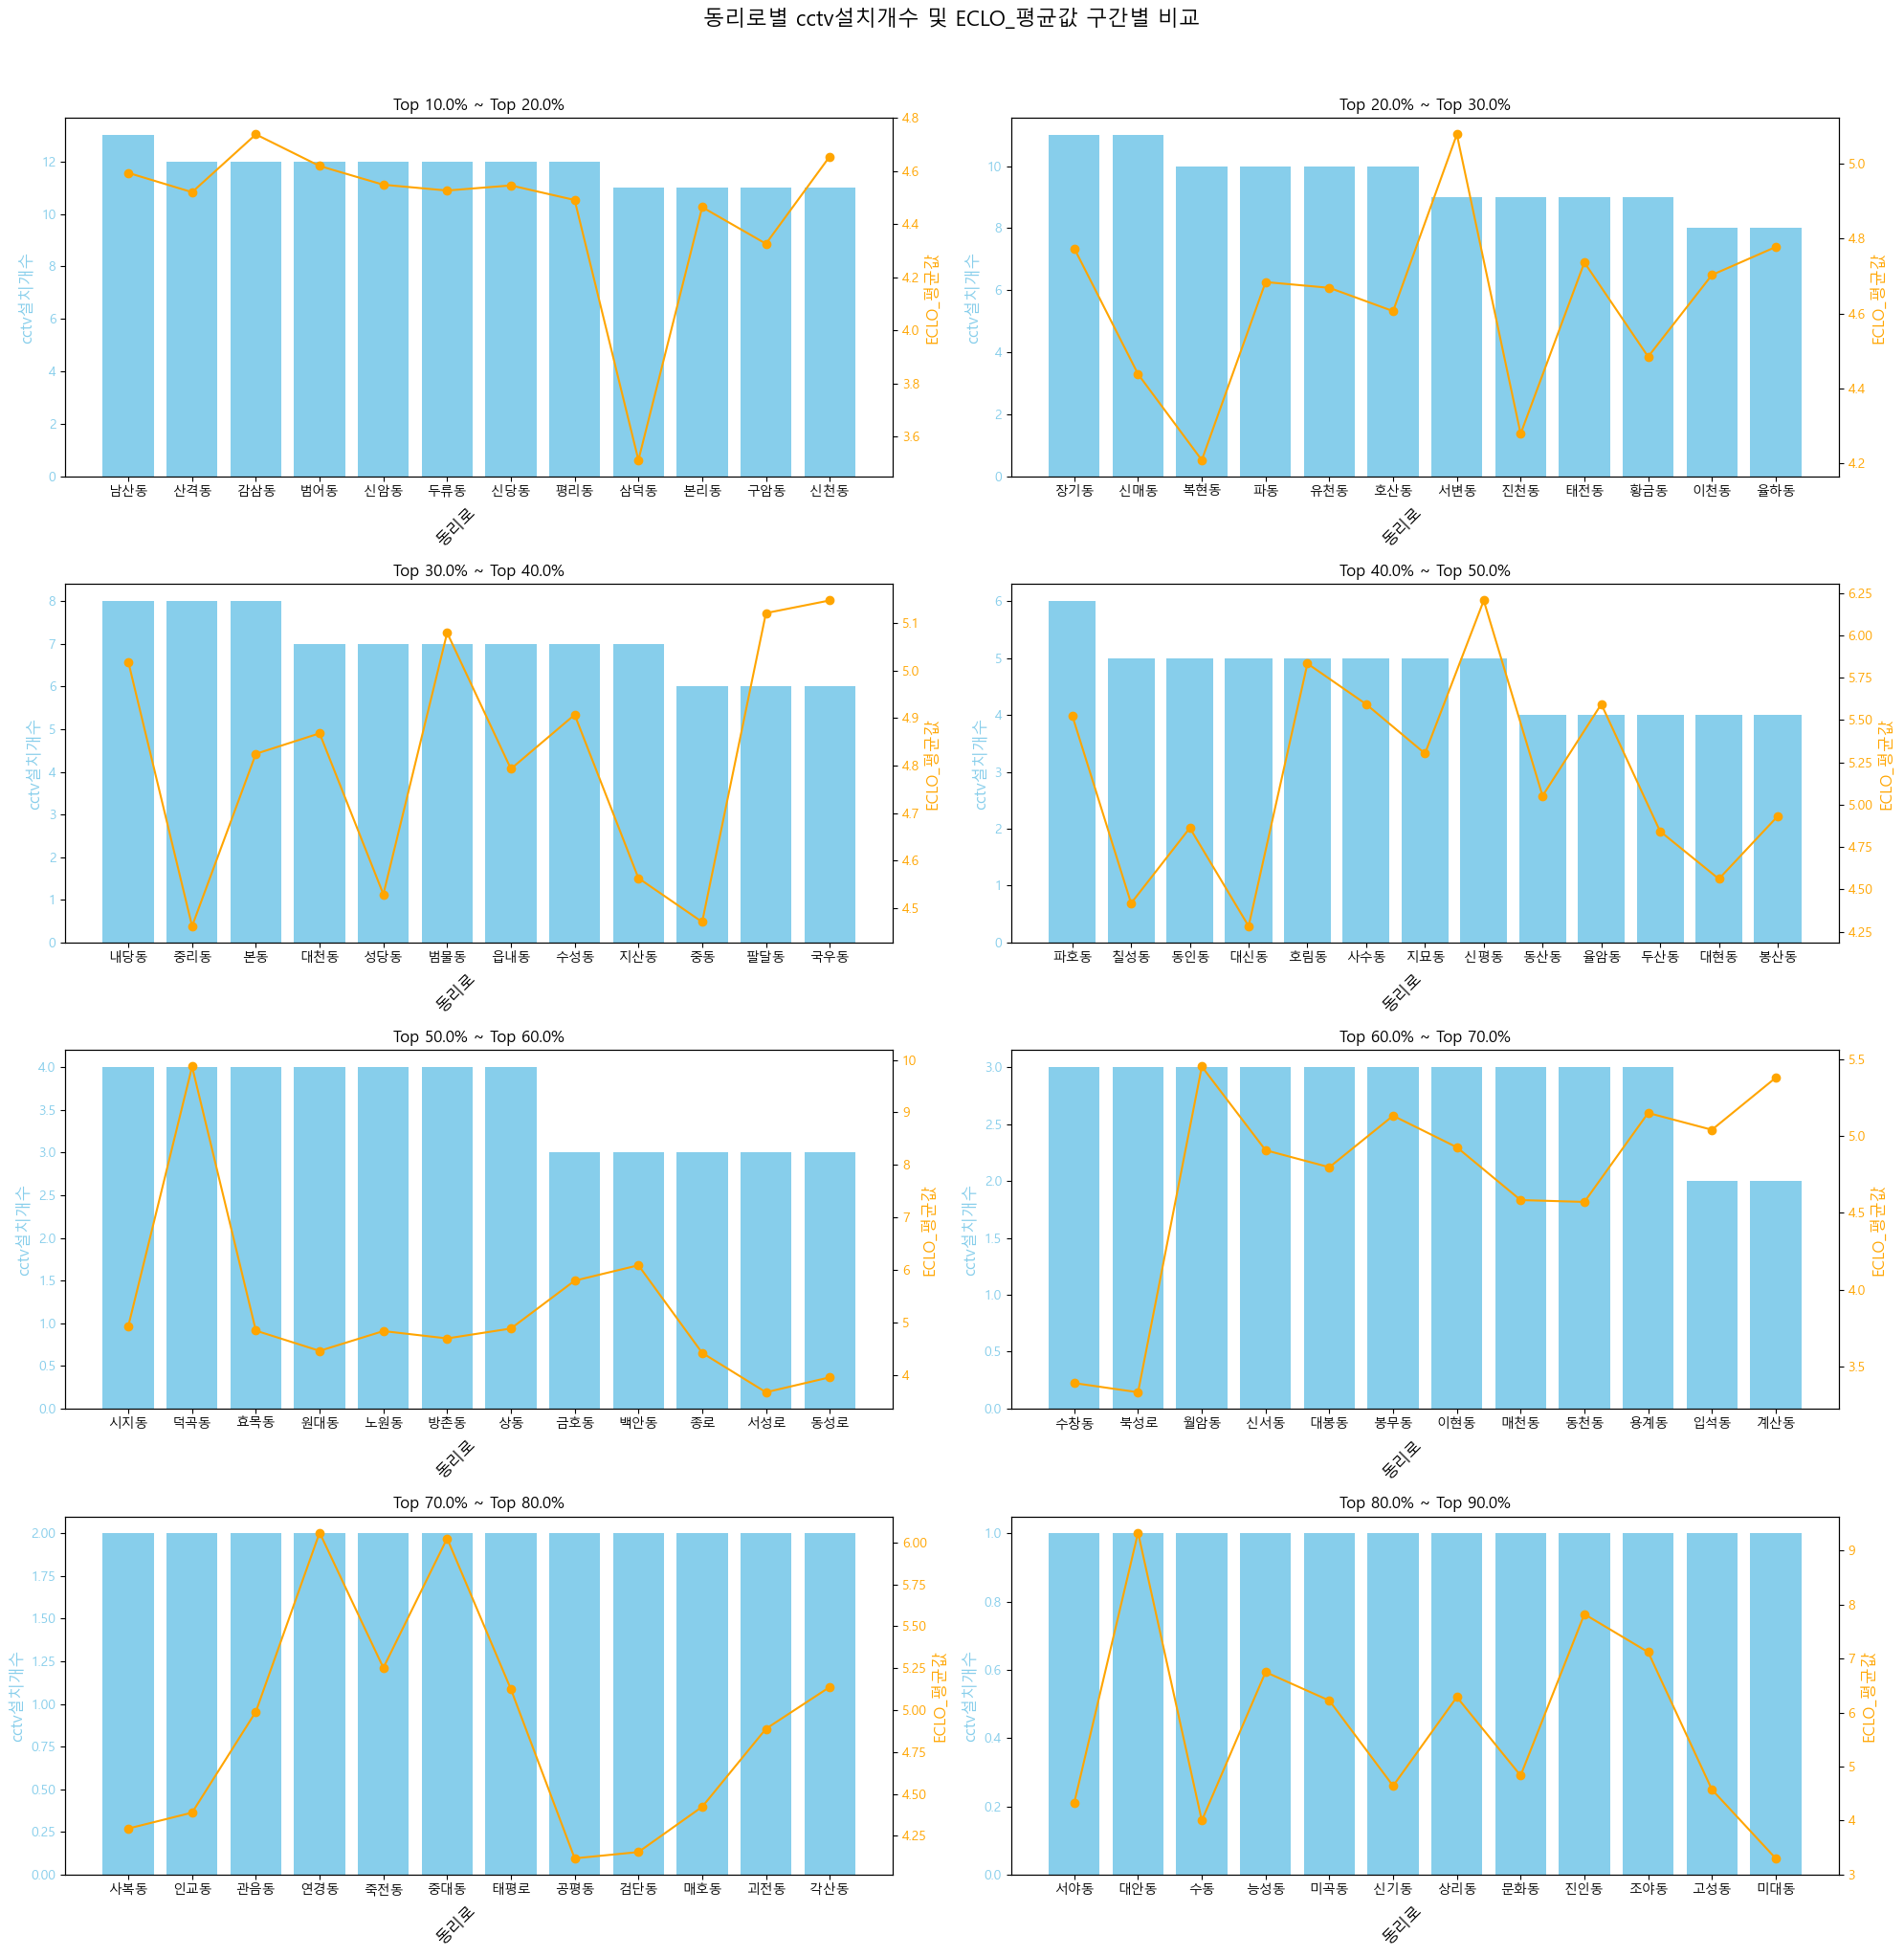

In [340]:
import matplotlib.pyplot as plt

# 데이터프레임 생성 (실제 데이터 프레임 사용)
merged_df = pd.merge(unique_dong_eclo_avg, cctv_counts_df, on='동리로', how='inner')
ol_df = pd.DataFrame(merged_df)
ol_df = ol_df.sort_values(by='cctv설치개수', ascending=False)
# 그래프 생성
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))
axes = axes.flatten()
# 각 구간별로 데이터 분할
percentiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in range(len(percentiles) - 1):
    lower_percent = percentiles[i]
    upper_percent = percentiles[i + 1]
    
    # 데이터프레임을 해당 구간에 맞게 분할
    subset_df = ol_df.iloc[int(lower_percent * len(ol_df)):int(upper_percent * len(ol_df))]
    # 서브플롯에 막대 그래프 및 선 그래프 플로팅
    ax = axes[i]
    ax.bar(subset_df['동리로'], subset_df['cctv설치개수'], color='skyblue', label='cctv설치개수')
    ax.set_xlabel('동리로', fontsize=12, rotation=45, ha='right')
    ax.set_ylabel('cctv설치개수', color='skyblue', fontsize=12)
    ax.tick_params(axis='y', labelcolor='skyblue')
    
    ax2 = ax.twinx()
    ax2.plot(subset_df['동리로'], subset_df['ECLO_평균값'], color='orange', marker='o', label='ECLO_평균값')
    ax2.set_ylabel('ECLO_평균값', color='orange', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='orange')
    
    ax.set_title(f'Top {lower_percent*100}% ~ Top {upper_percent*100}%')

plt.suptitle('동리로별 cctv설치개수 및 ECLO_평균값 구간별 비교', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


# 결론: CCTV-ECLO 상관분석

In [341]:
ol_df = pd.DataFrame(merged_df)
# 'ECLO_평균값'과 'cctv설치개수' 간의 상관 계수 계산
correlation = ol_df['ECLO_평균값'].corr(ol_df['cctv설치개수'])
print(f"상관 계수: {correlation}")

상관 계수: -0.2227957760682404


- -1과 멀다 그러므로 관계가 강해보이지는 않는다.